# AMEX Default Prediction

## Set up

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

In [2]:
pd.options.display.max_rows = 200
pd.options.display.max_info_columns = 200

## Data Import

#### Parquet Data

In [3]:
# # load parquet data
# data = pd.read_parquet('dataset/train.parquet')

#### Label Data

In [4]:
# raw_labels = pd.read_csv('dataset/train_labels.csv')

raw_labels is a maping from a unique customerID to a class (0 for compliance, 1 for default)

### Separate original data into train data and test data

In [5]:
# no_unique_customer_IDs = len(raw_labels["customer_ID"])
# K = no_unique_customer_IDs // 2 + 1

In [6]:
# train_customer_IDs = raw_labels["customer_ID"].iloc[:K]
# test_customer_IDs = raw_labels["customer_ID"].iloc[K:]

In [7]:
# train_data = data.loc[data["customer_ID"].isin(train_customer_IDs)].copy().reset_index(drop=True)

In [8]:
# test_data = data.loc[data["customer_ID"].isin(test_customer_IDs)].copy().reset_index(drop=True)

In [9]:
# train_customer_target_dict = dict(zip(train_customer_IDs, raw_labels["target"].loc[train_customer_IDs.index]))
# train_labels = pd.DataFrame(data=train_data["customer_ID"], columns=["customer_ID"])
# train_labels["target"] = train_data["customer_ID"].map(train_customer_target_dict)

In [10]:
# test_customer_target_dict = dict(zip(test_customer_IDs, raw_labels["target"].loc[test_customer_IDs.index]))
# test_labels = pd.DataFrame(data=test_data["customer_ID"], columns=["customer_ID"])
# test_labels["target"] = test_data["customer_ID"].map(test_customer_target_dict)

## Data Preprocessing

1. Set nan/-1 value to the mean of their class for each feature
1. Normalize data between 0 and 1

In [11]:
def preprocess_data(data: pd.DataFrame, labels: pd.DataFrame):
    columns = data.columns[2:]
    pbar = tqdm(range(len(columns)))

    for it in pbar: 
        feature = columns[it]
        feature_data = data[feature]
        no_nan = feature_data.isnull().sum()
        no_neg_one = (feature_data == -1).sum()

        if no_nan > 0:
            complete_data = feature_data.loc[np.logical_not(feature_data.isnull())]
            complete_labels = labels.loc[complete_data.index]
            nan_data = feature_data.loc[feature_data.isnull()]
            nan_labels = labels.loc[nan_data.index]
        elif no_neg_one > 0:
            complete_data = feature_data.loc[np.logical_not(feature_data == -1)]
            complete_labels = labels.loc[complete_data.index]
            nan_data = feature_data.loc[feature_data == -1]
            nan_labels = labels.loc[nan_data.index]
        else:
            # normalize data
            max_value = feature_data.max()
            min_value = feature_data.min()
            data[feature] = (data[feature] - min_value) / (max_value - min_value)
            continue

        # split complete_data into 2 classes: default and not_default
        default_mask = complete_labels["target"] == 1
        default_indices = complete_labels.loc[default_mask].index
        default_data = complete_data.loc[default_indices]
        mean_default_data = np.average(default_data)

        ndefault_mask = complete_labels["target"] == 0
        ndefault_indices = complete_labels.loc[ndefault_mask].index
        ndefault_data = complete_data.loc[ndefault_indices]
        mean_ndefault_data = np.average(ndefault_data)

        # split nan_data into 2 classes: default and not_default
        default_mask = nan_labels["target"] == 1
        default_indices = nan_labels.loc[default_mask].index
        data.loc[default_indices, feature] = mean_default_data

        ndefault_mask = nan_labels["target"] == 0
        ndefault_indices = nan_labels.loc[ndefault_mask].index
        data.loc[ndefault_indices, feature] = mean_ndefault_data

        # normalize data
        max_value = data[feature].max()
        min_value = data[feature].min()
        if (abs(max_value - min_value) > 0):
            data[feature] = (data[feature] - min_value) / (max_value - min_value)
        
        pbar.set_description('iter %d, feature: %s' % (it, feature))

In [12]:
# preprocess_data(train_data, train_labels)

iter 187, feature: D_145: 100%|██████████| 188/188 [00:56<00:00,  3.33it/s]


In [19]:
# train_data.to_parquet('dataset/normalized/train_data.parquet')
# train_labels.to_parquet('dataset/normalized/train_labels.parquet')

In [20]:
# preprocess_data(test_data, test_labels)

iter 187, feature: D_145: 100%|██████████| 188/188 [01:01<00:00,  3.07it/s]


In [25]:
# test_data.to_parquet('dataset/normalized/test_data.parquet')
# test_labels.to_parquet('dataset/normalized//test_labels.parquet')

### Deprecated Preprocessing Codes

In [ ]:
# columns = train_data.columns[2:]
# pbar = tqdm(range(len(columns)))

# for it in pbar: 
#     feature = columns[it]
#     feature_data = train_data[feature]
#     no_nan = feature_data.isnull().sum()
#     no_neg_one = (feature_data == -1).sum()

#     if no_nan > 0:
#         complete_data = feature_data.loc[np.logical_not(feature_data.isnull())]
#         complete_labels = train_labels.loc[complete_data.index]
#         nan_data = feature_data.loc[feature_data.isnull()]
#         nan_labels = train_labels.loc[nan_data.index]
#     elif no_neg_one > 0:
#         complete_data = feature_data.loc[np.logical_not(feature_data == -1)]
#         complete_labels = train_labels.loc[complete_data.index]
#         nan_data = feature_data.loc[feature_data == -1]
#         nan_labels = train_labels.loc[nan_data.index]
#     else:
#         # normalize data
#         max_value = feature_data.max()
#         min_value = feature_data.min()
#         train_data[feature] = (train_data[feature] - min_value) / (max_value - min_value)
#         continue

#     # split complete_data into 2 classes: default and not_default
#     default_mask = complete_labels["target"] == 1
#     default_indices = complete_labels.loc[default_mask].index
#     default_data = complete_data.loc[default_indices]
#     mean_default_data = np.average(default_data)

#     ndefault_mask = complete_labels["target"] == 0
#     ndefault_indices = complete_labels.loc[ndefault_mask].index
#     ndefault_data = complete_data.loc[ndefault_indices]
#     mean_ndefault_data = np.average(ndefault_data)

#     # split nan_data into 2 classes: default and not_default
#     default_mask = nan_labels["target"] == 1
#     default_indices = nan_labels.loc[default_mask].index
#     train_data.loc[default_indices, feature] = mean_default_data

#     ndefault_mask = nan_labels["target"] == 0
#     ndefault_indices = nan_labels.loc[ndefault_mask].index
#     train_data.loc[ndefault_indices, feature] = mean_ndefault_data

#     # normalize data
#     max_value = train_data[feature].max()
#     min_value = train_data[feature].min()
#     if (abs(max_value - min_value) > 0):
#         train_data[feature] = (train_data[feature] - min_value) / (max_value - min_value)
    
#     pbar.set_description('iter %d, feature: %s' % (it, feature))

## Dimensinality Reduction

In [26]:
train_data = pd.read_parquet('dataset/normalized/train_data.parquet')

In [27]:
numerical_data = train_data.iloc[:,2:]

In [28]:
test_data = pd.read_parquet('dataset/normalized/test_data.parquet')

In [29]:
numerical_test_data = test_data.iloc[:,2:]

In [30]:
from sklearn.decomposition import PCA

### PCA 95% Variance

In [31]:
pca = PCA(n_components=0.95)
pca_train_components = pca.fit(numerical_data).transform(numerical_data)
pca_test_components = pca.transform(numerical_test_data)

#### Export Data Projected onto PCA Components

In [35]:
# no_components = pca.explained_variance_ratio_.shape[0]
# columns = [f"Component {i}" for i in range(no_components)]
# df = pd.DataFrame(data=pca_train_components, columns=columns)
# df.to_parquet('dataset/pca/95Variance/train_data.parquet')

In [37]:
# no_components = pca.explained_variance_ratio_.shape[0]
# columns = [f"Component {i}" for i in range(no_components)]
# df = pd.DataFrame(data=pca_test_components, columns=columns)
# df.to_parquet('dataset/pca/95Variance/test_data.parquet')

### PCA 99% Variance

In [84]:
pca_99 = PCA(n_components=0.99)
pca_train_components = pca_99.fit(numerical_data).transform(numerical_data)
pca_test_components = pca_99.transform(numerical_test_data)

In [85]:
pca_99.explained_variance_ratio_.shape

(70,)

### PCA Component Visualization

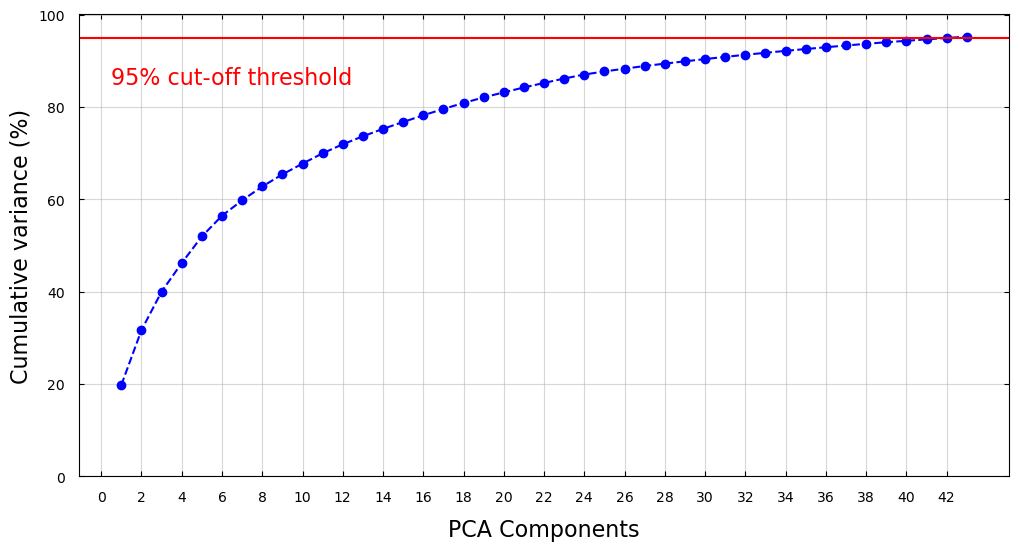

In [34]:
plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
xi = np.arange(1, 44, step=1)
y = np.cumsum(pca.explained_variance_ratio_*100)

plt.ylim(0.0, 100.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('PCA Components', fontsize=16, labelpad=10)
plt.ylabel('Cumulative variance (%)', fontsize=16)

plt.xticks(np.arange(0, 44, step=2))
plt.yticks(np.arange(0, 100.1, step=20))
plt.tick_params(axis="both",direction="in", pad=10)
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')

plt.axhline(y=95, color='r', linestyle='-')
plt.text(0.5, 85, '95% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='both', alpha=0.5)
plt.show()

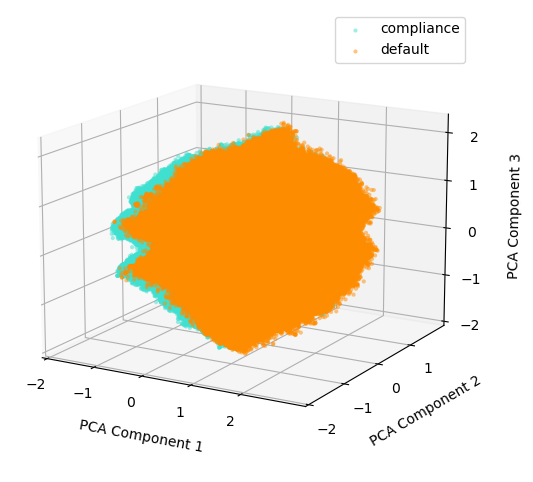

In [35]:
plt.rcParams["figure.figsize"] = (12,6)
target_names = ["compliance", "default"]
fig = plt.figure()
ax = fig.add_subplot(projection="3d")
colors = ["turquoise", "darkorange"]

for color, i, target_name in zip(colors, [0, 1], target_names):
    ax.scatter(
        data_r[train_labels["target"]==i, 0], data_r[train_labels["target"]==i, 1], data_r[train_labels["target"]==i, 2], 
        s=9, linewidths=0.0, alpha=0.5 ,color=color, label=target_name
    )

ax.set_xlabel("PCA Component 1", labelpad=10, rotation=0)
ax.set_ylabel("PCA Component 2", labelpad=10, rotation=0)
ax.set_zlabel("PCA Component 3", labelpad=10, rotation=0)

ax.set_xticks(np.arange(-2, 3, 1))
ax.set_yticks(np.arange(-2, 2, 1))
ax.set_zticks(np.arange(-2, 2.5, 1))

ax.legend(loc="best", shadow=False, scatterpoints=1)
ax.view_init(elev=15, azim=-60)

plt.show()

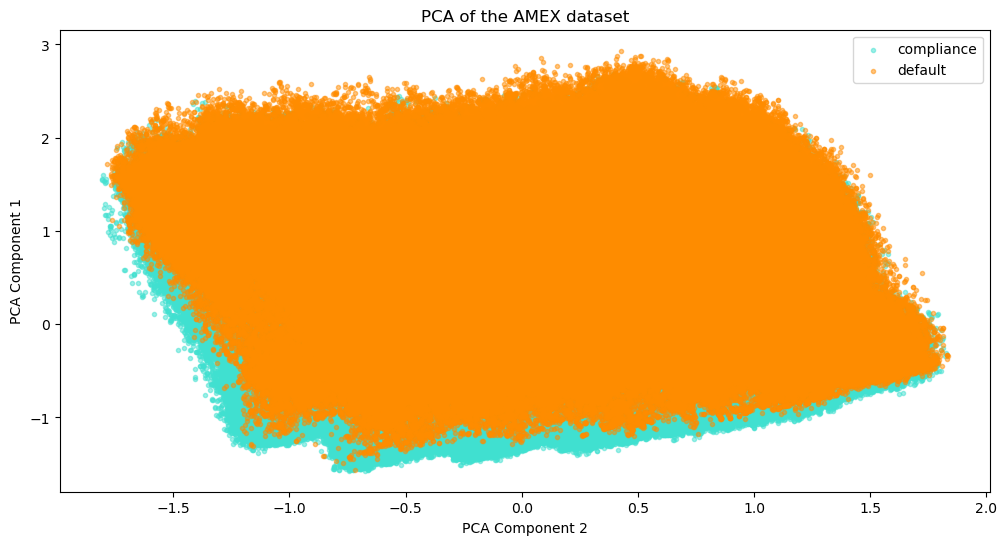

In [36]:
target_names = ["compliance", "default"]
fig = plt.figure()
colors = ["turquoise", "darkorange"]
marker_sizes = [9, 9]

for color, i, ms, target_name in zip(colors, [0, 1], marker_sizes, target_names):
    plt.scatter(
        data_r[train_labels["target"]==i, 1], data_r[train_labels["target"]==i, 0], s=ms, alpha=0.5 ,color=color, label=target_name
    )

plt.xlabel("PCA Component 2")
plt.ylabel("PCA Component 1")
plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title("PCA of the AMEX dataset")
plt.show()

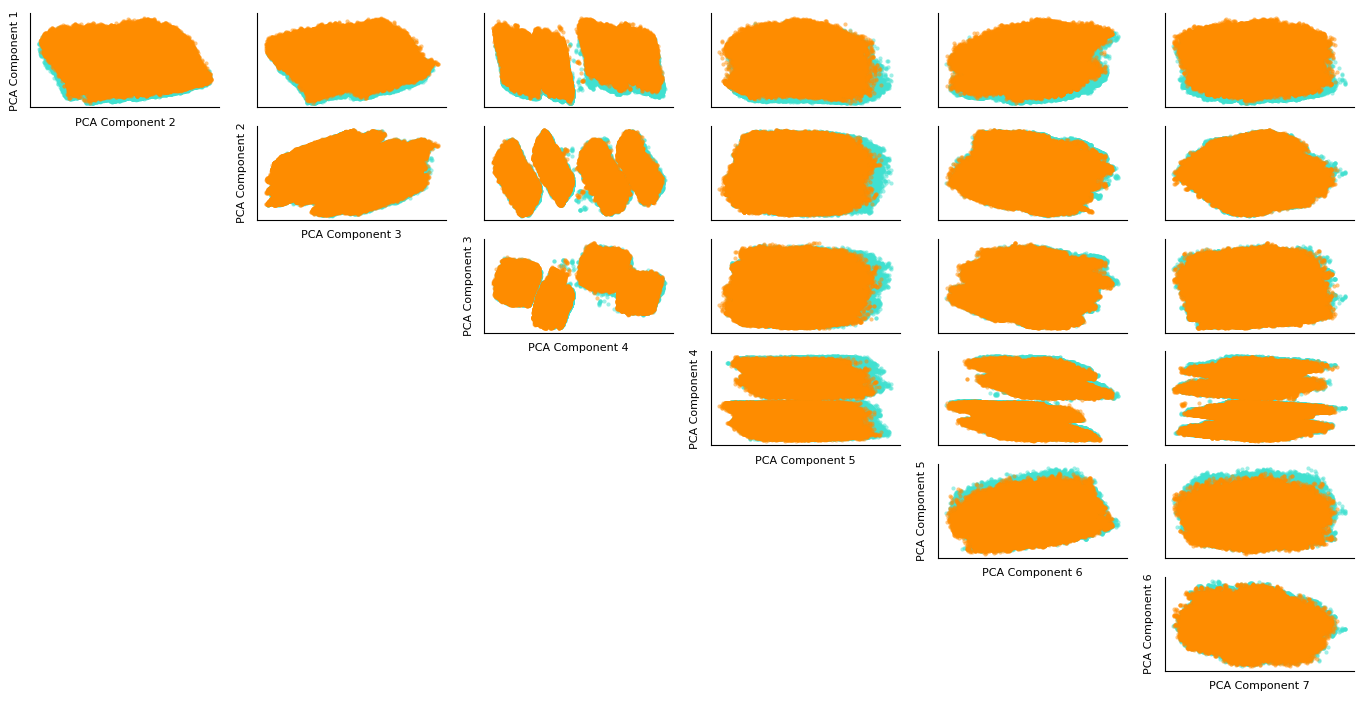

In [37]:
plt.rcParams["figure.figsize"] = (20,10)
components = 7
fig, axs = plt.subplots(components, components)
colors = ["turquoise", "darkorange"]

for r in range(components):
    for c in range(r+1, components):
        for color, i in zip(colors, [0, 1]):
            axs[r,c].scatter(
                data_r[train_labels["target"]==i, c], data_r[train_labels["target"]==i, r], 
                s=9, linewidths=0.0, alpha=0.5 ,color=color
            )
        if abs(c-r) == 1:
            axs[r,c].set_xlabel(f"PCA Component {c+1}", fontsize=8)
            axs[r,c].set_ylabel(f"PCA Component {r+1}", fontsize=8)

        axs[r,c].set_xticks([])
        axs[r,c].set_yticks([])
        axs[r,c].spines.right.set_visible(False)
        axs[r,c].spines.top.set_visible(False)

for r in range(components):
    for c in range(components):
        if r >= c:
            axs[r,c].set_visible(False)

plt.show()

## Unsupervised Method

### KMeans

In [38]:
from sklearn.cluster import KMeans
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, silhouette_score
from sklearn.metrics import DistanceMetric

In [41]:
# use the data that have been project onto 42 PCA components
data = pd.read_parquet('dataset/pca/95Variance/train_data.parquet').values
kmeans = KMeans(n_clusters=2).fit(data)

In [42]:
kmeans_labels = kmeans.labels_
trainning_labels = pd.read_parquet('dataset/normalized/train_labels.parquet')["target"].values

# determine which cluster predict which labels
n00 = np.sum(np.logical_and(kmeans_labels==0, trainning_labels==0))
n01 = np.sum(np.logical_and(kmeans_labels==0, trainning_labels==1))
n10 = np.sum(np.logical_and(kmeans_labels==1, trainning_labels==0))
n11 = np.sum(np.logical_and(kmeans_labels==1, trainning_labels==1))

table = pd.DataFrame(data=np.array([[n00, n01], [n10, n11]]), columns=["Label 0", "Label 1"], index=["Cluster 0", "Cluster 1"])
table

,Label 0,Label 1
Cluster 0,494265,534385
Cluster 1,1581176,156817


The majority of Cluster 0 (~ 52%) vote for the Default label, so Cluster 0 will map to label 1.  

The vast majority of Cluster 1 (~ 91%) vote for the Compliance label, so Cluster 1 will map to label 0.  


#### External Evaluation

In [43]:
# kmeans on test data
predicts = kmeans.predict(pca_test_components) ^ 1

# load the ground truths
truths = pd.read_parquet('dataset/normalized/test_labels.parquet')['target'].values

In [44]:
def purities(model_labels: np.ndarray, ground_truths: np.ndarray):
    # Calculating purity value
    size_cluster0 = np.sum(model_labels==0)
    n00 = np.sum(np.logical_and(model_labels==0, ground_truths==0))
    n01 = np.sum(np.logical_and(model_labels==0, ground_truths==1))
    purity_cluster0 = max(n00,n01)/size_cluster0
    print("Purity of cluster 0 is ", purity_cluster0)

    size_cluster1 = np.sum(model_labels==1)
    n10 = np.sum(np.logical_and(model_labels==1, ground_truths==0))
    n11 = np.sum(np.logical_and(model_labels==1, ground_truths==1))
    purity_cluster1 = max(n10,n11)/size_cluster1
    print("Purity of cluster 1 is ", purity_cluster1)

    n = size_cluster0 + size_cluster1
    total_purity = size_cluster0/n * purity_cluster0 + size_cluster1/n * purity_cluster1
    print("Total purity is ", total_purity)

    cm = pd.DataFrame(data=np.array([[n00, n01], [n10, n11]]), columns=["Label 0", "Label 1"], index=["Cluster 0", "Cluster 1"])
    print("Confusion matrix:\n", cm)

    return (n00, n01, n10, n11)

In [45]:
n00, n01, n10, n11 = purities(predicts, truths)

Purity of cluster 0 is  0.9110719403725221
Purity of cluster 1 is  0.5183259639822356
Total purity is  0.7652487984699118
Confusion matrix:
            Label 0  Label 1
Cluster 0  1583679   154580
Cluster 1   494462   532087


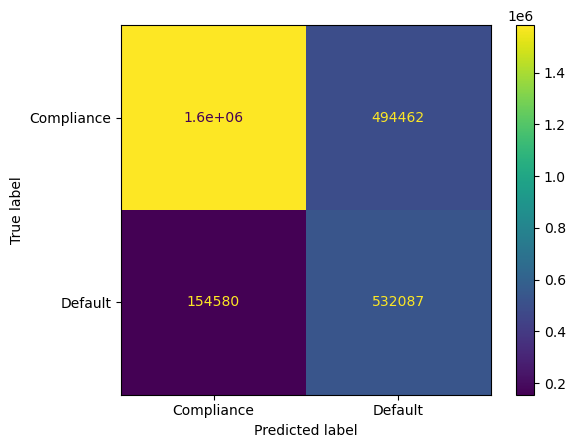

In [46]:
cm = confusion_matrix(truths, predicts)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Compliance", "Default"])
cm_display.plot()
plt.show()

In [47]:
# Precision, Recall, Accuracy, F-measure
# Cluster 0 will correspond to the class label 1 or "Default"
# Cluster 1 will correspond to the class label 0 or "Compliance"
true_positive = n00
false_positive = n01
false_negative = n10
true_negative = n11

print("For cluster 0 / Compliance label:")
precision = true_positive / (true_positive + false_positive)
print("     The precision score is ", precision)
recall = true_positive / (true_positive + false_negative)
print("     The recall score is ", recall)
accuracy = (true_positive + true_negative) / (true_positive + true_negative + false_negative + false_positive)
print("     The accuracy score is ", accuracy)
fmeasure = 2/(1/precision + 1/recall)
print("     F-Measure: ", fmeasure)

print("\n")
print("For cluster 1 / Default label:")
precision = true_negative / (true_negative + false_negative)
print("     The precision score is ", precision)
recall = true_negative / (true_negative + false_positive)
print("     The recall score is ", recall)
accuracy = (true_positive + true_negative) / (true_positive + true_negative + false_negative + false_positive)
print("     The accuracy score is ", accuracy)
fmeasure = 2/(1/precision + 1/recall)
print("     F-Measure: ", fmeasure)

For cluster 0 / Compliance label:
     The precision score is  0.9110719403725221
     The recall score is  0.7620652304150681
     The accuracy score is  0.7652487984699118
     F-Measure:  0.8299334451315377


For cluster 1 / Default label:
     The precision score is  0.5183259639822356
     The recall score is  0.7748836044254347
     The accuracy score is  0.7652487984699118
     F-Measure:  0.621155767865815


#### Internal Measures

In [51]:
silhouette = silhouette_score(data, kmeans_labels, sample_size=10000, random_state=1)

In [52]:
silhouette

0.18761544134273003

This silhouette value is close to 0, indicating overlapping clusters